<a href="https://colab.research.google.com/github/denizmsayin/singan/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

torch.__version__

'1.5.0+cu101'

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [0]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xvzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [0]:
class Conv2DBlock(nn.Module):
  """ Combine Conv2d-BN-LReLU into a single block """
  # the 0.2 negative slope is given in the supplementary materials
  def __init__(self, in_channels, out_channels, kernel_size, activation, conv_kwargs={}, bn_kwargs={}):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **conv_kwargs)
    self.bn = nn.BatchNorm2d(out_channels, **bn_kwargs)
    self.activ = activation

  def forward(self, x):
    return self.activ(self.bn(self.conv(x)))

class SGNet(nn.Module):
  def __init__(self, output_channels=3, kernel_count=32, final_activation=nn.Tanh(), final_bn=True, num_blocks=5):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.ZeroPad2d(num_blocks)) # initial padding, as explained in the SM
    in_channels = 3
    for _ in range(num_blocks-1): # multiple Conv2D blocks with LeakyReLU
      self.layers.append(Conv2DBlock(in_channels, kernel_count, 3, nn.LeakyReLU(negative_slope=0.2)))
      in_channels = kernel_count
    # the final activation depends on whether this is the generator or critic
    if final_bn:
      self.layers.append(Conv2DBlock(kernel_count, output_channels, 3, final_activation))
    else:
      self.layers.append(nn.Conv2d(kernel_count, output_channels, 3))
      self.layers.append(final_activation)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

class Mean(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.mean(x)
  

Dataset already downloaded


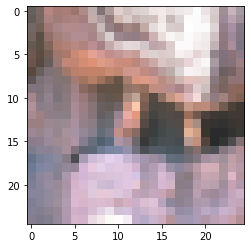

In [12]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize((25, 25), Image.BICUBIC))
plt.imshow(orig_img_uint)

In [0]:
# as given in the paper (LR decrease not implemented)
LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1

PRINT_EVERY = 50
DEVICE = 'cuda'

SGNet(
  (layers): ModuleList(
    (0): ZeroPad2d(padding=(5, 5, 5, 5), value=0.0)
    (1): Conv2DBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2DBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2DBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
    (4): Conv2DBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.2)
    )
  

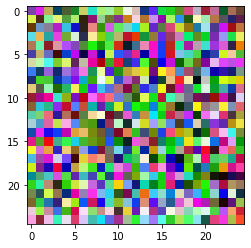

Step: 50
Generator adv: -31.151, rec: 748.406
Critic fake: -18.743 real: -14.187 grad: 17.796
Steps per second: 14.21


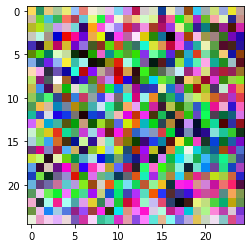

Step: 100
Generator adv: -73.890, rec: 572.034
Critic fake: -43.032 real: -30.859 grad: 0.003
Steps per second: 14.13


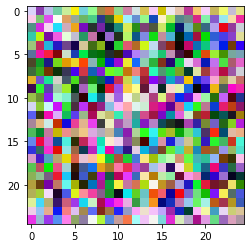

Step: 150
Generator adv: -119.373, rec: 526.020
Critic fake: -69.402 real: -51.305 grad: 13.343
Steps per second: 14.06


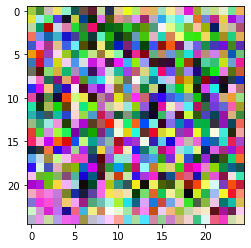

Step: 200
Generator adv: -144.816, rec: 492.201
Critic fake: -88.951 real: -70.834 grad: 149.683
Steps per second: 14.15


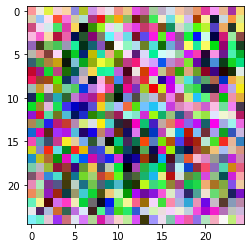

Step: 250
Generator adv: -222.496, rec: 382.659
Critic fake: -137.899 real: -94.226 grad: 96.293
Steps per second: 14.11


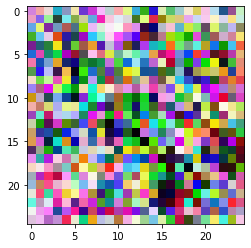

Step: 300
Generator adv: -292.531, rec: 316.213
Critic fake: -166.936 real: -134.960 grad: 93.646
Steps per second: 14.23


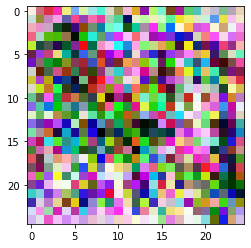

Step: 350
Generator adv: -141.458, rec: 281.559
Critic fake: -141.708 real: -6.913 grad: 71.629
Steps per second: 14.08


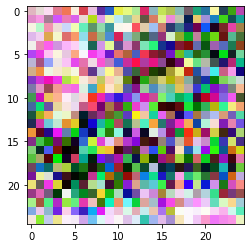

Step: 400
Generator adv: -184.793, rec: 248.578
Critic fake: -220.558 real: 25.329 grad: 104.357
Steps per second: 13.86


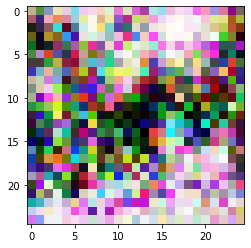

Step: 450
Generator adv: -295.471, rec: 239.196
Critic fake: -156.174 real: -192.724 grad: 534.272
Steps per second: 13.98


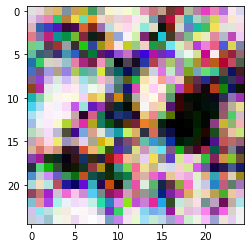

Step: 500
Generator adv: -256.831, rec: 136.183
Critic fake: -195.196 real: -204.961 grad: 1433.258
Steps per second: 14.09


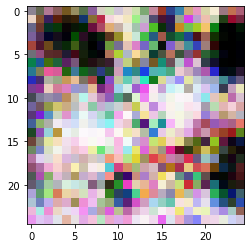

Step: 550
Generator adv: -286.241, rec: 131.000
Critic fake: -149.123 real: -219.947 grad: 828.289
Steps per second: 14.05


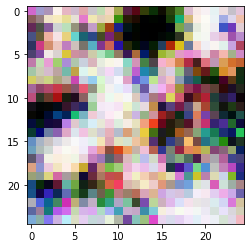

Step: 600
Generator adv: -89.702, rec: 125.966
Critic fake: -147.617 real: -239.088 grad: 2970.036
Steps per second: 14.19


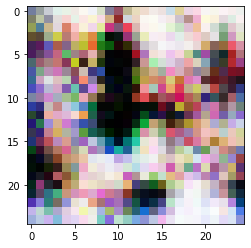

Step: 650
Generator adv: -244.309, rec: 121.646
Critic fake: -225.236 real: -129.055 grad: 1099.816
Steps per second: 14.17


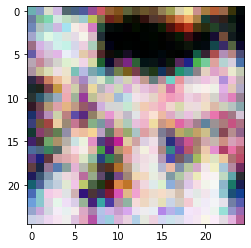

Step: 700
Generator adv: -238.899, rec: 109.866
Critic fake: -205.645 real: -254.969 grad: 2217.148
Steps per second: 14.25


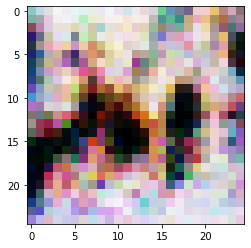

Step: 750
Generator adv: -244.475, rec: 65.470
Critic fake: -251.061 real: -34.675 grad: 412.612
Steps per second: 14.11


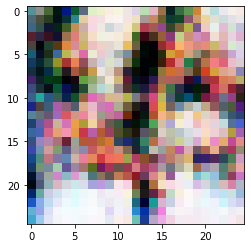

Step: 800
Generator adv: -342.825, rec: 68.262
Critic fake: -251.148 real: -302.768 grad: 2110.910
Steps per second: 14.03


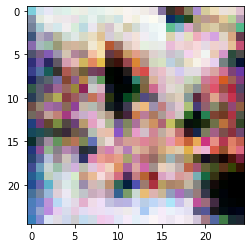

Step: 850
Generator adv: -296.195, rec: 61.048
Critic fake: -231.763 real: -269.260 grad: 2048.285
Steps per second: 14.22


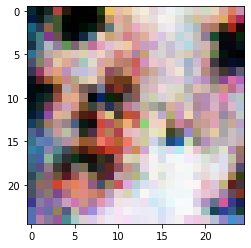

Step: 900
Generator adv: -236.902, rec: 46.346
Critic fake: -156.214 real: -292.547 grad: 2118.582
Steps per second: 14.11


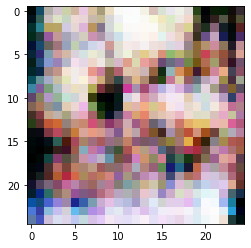

Step: 950
Generator adv: -437.669, rec: 40.007
Critic fake: -238.921 real: -306.950 grad: 1082.021
Steps per second: 13.86


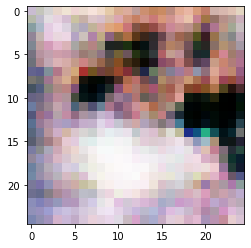

Step: 1000
Generator adv: -307.258, rec: 36.243
Critic fake: -178.552 real: -324.639 grad: 1959.332
Steps per second: 14.02


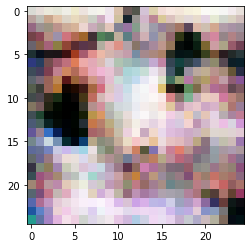

Step: 1050
Generator adv: -318.730, rec: 32.423
Critic fake: -118.922 real: -349.625 grad: 1498.172
Steps per second: 13.61


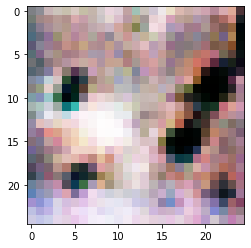

Step: 1100
Generator adv: -309.498, rec: 23.865
Critic fake: -130.514 real: -364.962 grad: 1859.784
Steps per second: 13.66


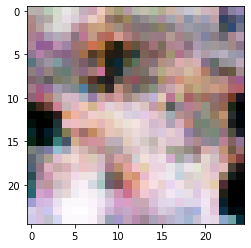

Step: 1150
Generator adv: -377.287, rec: 17.001
Critic fake: -139.426 real: -380.909 grad: 1430.480
Steps per second: 13.92


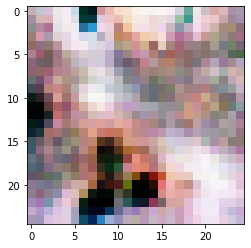

Step: 1200
Generator adv: -295.973, rec: 15.910
Critic fake: 3.783 real: -420.326 grad: 1205.707
Steps per second: 13.81


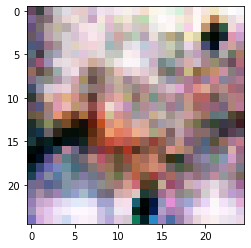

Step: 1250
Generator adv: -239.551, rec: 11.661
Critic fake: -134.539 real: -267.371 grad: 1623.585
Steps per second: 13.80


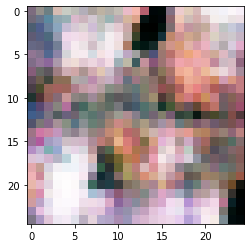

Step: 1300
Generator adv: -333.385, rec: 11.600
Critic fake: -89.691 real: -450.420 grad: 2067.263
Steps per second: 13.52


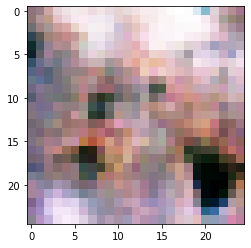

Step: 1350
Generator adv: -254.229, rec: 6.794
Critic fake: -106.714 real: -206.350 grad: 588.348
Steps per second: 13.49


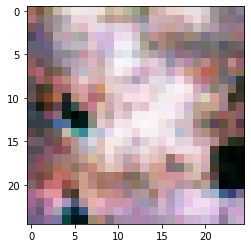

Step: 1400
Generator adv: -293.005, rec: 6.558
Critic fake: -55.966 real: -442.414 grad: 2053.752
Steps per second: 13.43


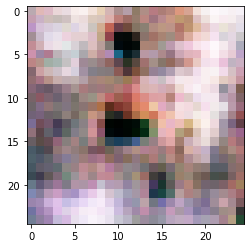

Step: 1450
Generator adv: -546.252, rec: 7.314
Critic fake: -117.949 real: -542.832 grad: 1145.281
Steps per second: 13.54


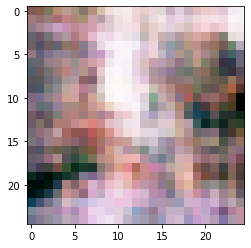

Step: 1500
Generator adv: -363.243, rec: 6.795
Critic fake: 47.301 real: -557.043 grad: 1464.984
Steps per second: 13.63


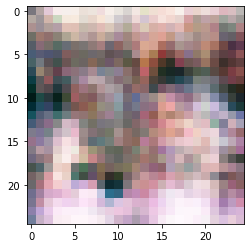

Step: 1550
Generator adv: -232.235, rec: 2.847
Critic fake: 119.233 real: -539.726 grad: 1882.576
Steps per second: 13.81


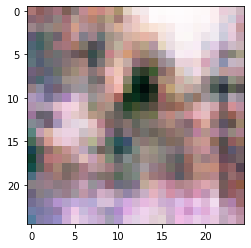

Step: 1600
Generator adv: -313.609, rec: 1.866
Critic fake: 97.174 real: -592.621 grad: 1818.384
Steps per second: 13.96


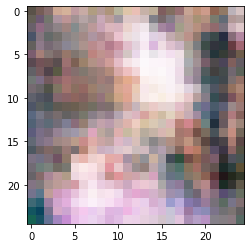

Step: 1650
Generator adv: -361.867, rec: 1.088
Critic fake: 30.668 real: -583.692 grad: 1911.558
Steps per second: 13.82


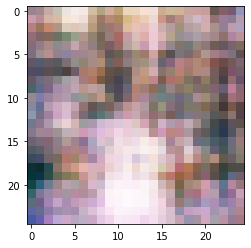

Step: 1700
Generator adv: -241.729, rec: 1.056
Critic fake: 74.009 real: -559.793 grad: 2440.552
Steps per second: 14.03


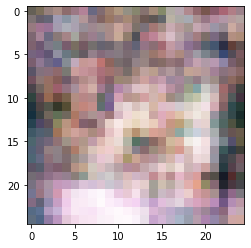

Step: 1750
Generator adv: 0.779, rec: 1.106
Critic fake: 68.927 real: -627.173 grad: 5590.248
Steps per second: 13.90


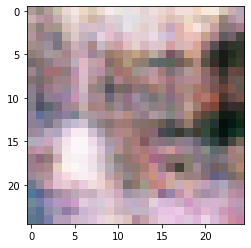

Step: 1800
Generator adv: -193.888, rec: 1.252
Critic fake: 199.871 real: -714.216 grad: 3204.576
Steps per second: 13.82


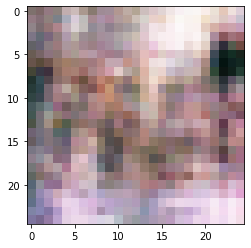

Step: 1850
Generator adv: -262.061, rec: 0.815
Critic fake: 75.261 real: -725.104 grad: 3877.827
Steps per second: 13.83


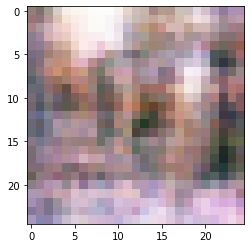

Step: 1900
Generator adv: -201.549, rec: 0.929
Critic fake: 285.442 real: -698.125 grad: 2111.336
Steps per second: 13.90


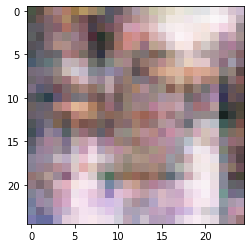

Step: 1950
Generator adv: -264.422, rec: 0.652
Critic fake: 74.350 real: -756.957 grad: 4181.854
Steps per second: 13.88


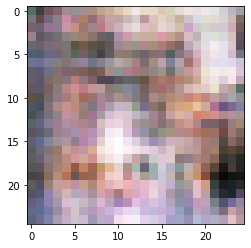

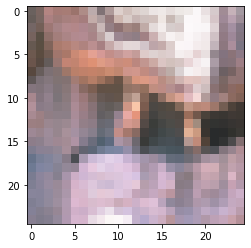

In [14]:


def img2net(img_uint):
  # convert [0, 255] uint8 (H, W, C) to [-1, 1] float32 (1, C, H, W)
  rescaled = (img_uint.astype('float32') / 127.5) - 1.0
  chw = np.transpose(rescaled, (2, 0, 1))
  return torch.from_numpy(np.expand_dims(chw, axis=0)).to(DEVICE)

def net2img(img_float):
  chw = np.squeeze(img_float.detach().cpu().numpy())
  hwc = np.transpose(chw, (1, 2, 0))
  return ((hwc + 1.0) * 127.5).astype('uint8')

generator = SGNet(output_channels=3, kernel_count=64).to(DEVICE)
patch_critic = SGNet(output_channels=1, kernel_count=64, final_activation=nn.Identity(), final_bn=False).to(DEVICE)
critic = torch.nn.Sequential(patch_critic, Mean()).to(DEVICE)
print(generator)
print(critic)

gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
dis_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))

orig_img = img2net(orig_img_uint)
print(orig_img.shape)

def sample_noise(): # check this
  return torch.from_numpy(np.random.uniform(-1, 1, size=orig_img.shape).astype('float32')).to(DEVICE)

z_rec = sample_noise()
mse = nn.MSELoss()

for step in range(NUM_ITERS):

  # real 1, fake 0

  for _ in range(GEN_STEP_PER_ITER):
    gen_optimizer.zero_grad()

    z = sample_noise()
    fake_img = generator(z)

    # adversarial loss
    adv_loss = -critic(fake_img)

    # reconstruction loss
    rec_img = generator(z_rec)
    # the representation space of the images is not clear in the paper.
    # since the reconstruction loss seemed very low to us in the [-1, 1]
    # range, we decided to calculate it in the [0, 255] range instead
    rec_loss = 127.5**2 * mse(orig_img, rec_img)

    gen_loss = adv_loss + REC_ALPHA * rec_loss
    gen_loss.backward()
    gen_optimizer.step()

  for _ in range(DIS_STEP_PER_ITER):
    dis_optimizer.zero_grad()

    zc = sample_noise()
    fake_imgc = generator(zc)
    epsilon = np.random.uniform(0, 1)

    # adversarial loss
    # take a sample from the line between the real and generated images
    # for use in the gradient penalty (Impr. Training of WGANs)
    grad_sample = epsilon * orig_img + (1 - epsilon) * fake_imgc
    f_grad_sample = critic(grad_sample)
    grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True, retain_graph=True)
    grad_loss = (torch.norm(grad) - 1)**2

    fake_loss = critic(fake_imgc)
    real_loss = -critic(orig_img)
    adv_loss =  fake_loss + real_loss + GP_WEIGHT * grad_loss
    adv_loss.backward()
    dis_optimizer.step()

  if step % PRINT_EVERY == 0:
    print('Step: {}'.format(step))
    print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.data, rec_loss.data))
    print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.data, real_loss.data, grad_loss.data))
    if step != 0:
      elapsed = time() - last_print
      print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
    plt.imshow(net2img(fake_img))
    plt.show()
    last_print = time()

plt.imshow(net2img(generator(z_rec)))
plt.show()
